# Movie Recommendation System

## Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from surprise import Dataset, Reader
from surprise import SVD # implementation of Funk's SVD (gradient descent-based matrix factorization)
from surprise import accuracy # metric
from surprise.model_selection import train_test_split, GridSearchCV, cross_validate #train/test splits, crossval
from collections import defaultdict

## Files

### Load in Files

In [4]:
ratings = pd.read_csv('DATA/ratings.csv', index_col=False)
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,1225734739
1,1,110,4.0,1225865086
2,1,158,4.0,1225733503
3,1,260,4.5,1225735204
4,1,356,5.0,1225735119


In [5]:
movies = pd.read_csv('DATA/movies.csv', index_col=False)
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


### Merge

In [6]:
mr = pd.merge(ratings, movies, on='movieId', how='outer')
mr.head()

,userId,movieId,rating,timestamp,title,genres
0,1.0,1,4.0,1.225735e+09,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2.0,1,5.0,8.358160e+08,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7.0,1,4.0,9.745180e+08,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,10.0,1,3.0,1.430666e+09,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,12.0,1,5.0,8.625007e+08,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


### Filter

In [7]:
mr = mr.dropna()

In [8]:
mr['userId'] = mr['userId'].astype(int)
mr

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,1.225735e+09,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,1,5.0,8.358160e+08,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.0,9.745180e+08,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,10,1,3.0,1.430666e+09,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,12,1,5.0,8.625007e+08,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
...,...,...,...,...,...,...
33835455,47791,288967,3.5,1.689748e+09,State of Siege: Temple Attack (2021),Action|Drama
33835456,98408,288971,0.5,1.689798e+09,Ouija Japan (2021),Action|Horror
33835457,154483,288975,4.0,1.689812e+09,The Men Who Made the Movies: Howard Hawks (1973),Documentary
33835458,291389,288977,3.0,1.689816e+09,Skinford: Death Sentence (2023),Crime|Thriller


In [9]:
sample = mr.sample(n=3000000, random_state=1)
sample

,userId,movieId,rating,timestamp,title,genres
33182245,243485,190973,2.5,1.538803e+09,Hidden Reserves (2017),Drama|Sci-Fi
16176049,71415,3005,4.0,9.568581e+08,"Bone Collector, The (1999)",Thriller
32084944,171084,138036,4.0,1.569437e+09,The Man from U.N.C.L.E. (2015),Action|Adventure|Comedy
6082545,256240,805,5.0,8.592083e+08,"Time to Kill, A (1996)",Drama|Thriller
16125818,93175,2997,3.5,1.677810e+09,Being John Malkovich (1999),Comedy|Drama|Fantasy
...,...,...,...,...,...,...
29704749,312288,90645,3.0,1.327373e+09,Anonymous (2011),Drama
11211111,40095,1704,5.0,9.938466e+08,Good Will Hunting (1997),Drama|Romance
3233117,22946,357,3.0,1.275860e+09,Four Weddings and a Funeral (1994),Comedy|Romance
9600547,217248,1307,3.0,1.263824e+09,When Harry Met Sally... (1989),Comedy|Romance


### Sample

In [10]:
count = sample['userId'].value_counts()

In [11]:
valid_user = count[count > 150].index

In [12]:
sample_f = sample[sample['userId'].isin(valid_user)]

In [13]:
sample_f['userId'].value_counts()

userId
189614    2949
48766      851
76618      837
207216     817
175998     809
          ... 
9012       151
136471     151
328058     151
278369     151
36774      151
Name: count, Length: 1006, dtype: int64

## Model

In [14]:
reader = Reader(rating_scale=(0, 5))
data_gen = Dataset.load_from_df(sample_f[['userId', 'movieId', 'rating']], reader=reader)

In [15]:
trainset, testset = train_test_split(data_gen, test_size=.2, random_state = 42)

In [16]:
# instantiate SVD and fit the trainset
svd = SVD(n_epochs=50)
svd.fit(trainset)

In [17]:
prediction = svd.test(testset)

In [18]:
print(accuracy.rmse(prediction))
print(accuracy.mae(prediction))
print(accuracy.fcp(prediction))

RMSE: 0.8761
0.8760843325488136
MAE:  0.6677
0.6676846096788609
FCP:  0.6259
0.6259473195195397


### Cross Validation

In [19]:
results = cross_validate(svd, data_gen, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8738  0.8746  0.8740  0.8771  0.8722  0.8743  0.0016  
MAE (testset)     0.6673  0.6678  0.6679  0.6691  0.6643  0.6673  0.0016  
Fit time          6.02    6.19    5.53    5.30    5.36    5.68    0.36    
Test time         0.24    0.23    0.14    0.14    0.14    0.18    0.05    


In [20]:
print("Average RMSE with default parameters: ", results['test_rmse'].mean())
print("Average MAE with default parameters: ", results['test_mae'].mean())

Average RMSE with default parameters:  0.8743437780848374
Average MAE with default parameters:  0.6672746584172468


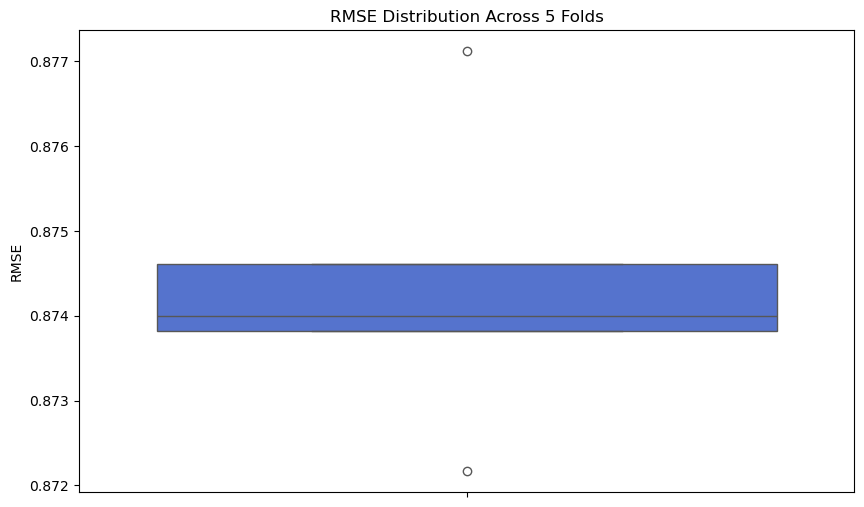

In [21]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=results['test_rmse'], color='royalblue')
plt.title('RMSE Distribution Across 5 Folds')
plt.ylabel('RMSE')
plt.show()

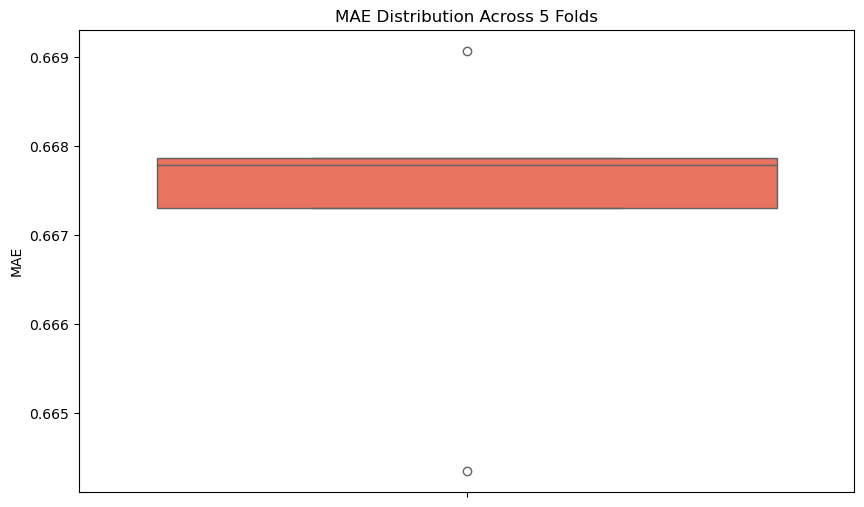

In [22]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=results['test_mae'], color='tomato')
plt.title('MAE Distribution Across 5 Folds')
plt.ylabel('MAE')
plt.show()


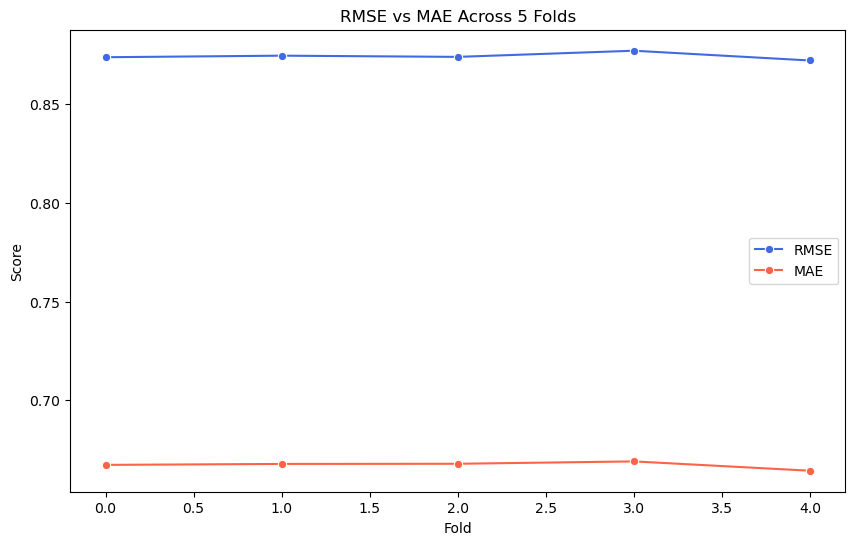

In [23]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=results['test_rmse'], label='RMSE', marker='o', color='royalblue')
sns.lineplot(data=results['test_mae'], label='MAE', marker='o', color='tomato')
plt.title('RMSE vs MAE Across 5 Folds')
plt.xlabel('Fold')
plt.ylabel('Score')
plt.legend()
plt.show()

----------

In [24]:
param_grid = {
    'n_factors': [50, 100, 150],
    'reg_all': [0.01, 0.1, 0.2],
    'lr_all': [0.005, 0.01, 0.05]
}

In [25]:
grid_search = GridSearchCV(SVD, param_grid, measures=['RMSE', 'MAE'], cv=5)
grid_search.fit(data_gen)

In [26]:
print("Best parameters found: ", grid_search.best_params)
print("Best RMSE: ", grid_search.best_score['rmse'])
print("Best MAE: ", grid_search.best_score['mae'])

Best parameters found:  {'rmse': {'n_factors': 150, 'reg_all': 0.1, 'lr_all': 0.05}, 'mae': {'n_factors': 150, 'reg_all': 0.1, 'lr_all': 0.05}}
Best RMSE:  0.8419413710598732
Best MAE:  0.6427365547126527


## Recommendation

In [ ]:
# finding a user to get a recommendation on

user_id = 278369

In [28]:
# sample_f[sample_f['userId'] == user_id]

### What user rated highly

In [29]:
sample_f[sample_f['userId'] == user_id].sort_values('rating', ascending=False)[:5]

,userId,movieId,rating,timestamp,title,genres
25601936,278369,44191,4.5,1.439574e+09,V for Vendetta (2006),Action|Sci-Fi|Thriller|IMAX
30220880,278369,97913,4.0,1.439597e+09,Wreck-It Ralph (2012),Animation|Comedy
28790409,278369,78637,4.0,1.439600e+09,Shrek Forever After (a.k.a. Shrek: The Final C...,Adventure|Animation|Children|Comedy|Fantasy|IMAX
23511165,278369,7451,3.5,1.439574e+09,Mean Girls (2004),Comedy
24721844,278369,30816,3.5,1.439575e+09,"Phantom of the Opera, The (2004)",Drama|Musical|Romance


### What is recommended to user

In [30]:
def get_movie_recommendations(user_id, top_n=5):
    # Get all movie IDs
    all_movie_ids = sample_f['movieId'].unique()
    
    # Get the movies the user has already rated
    rated_movie_ids = sample_f[sample_f['userId'] == user_id]['movieId'].tolist()
    
    # Predict ratings for all movies the user has not rated
    predictions = []
    for movie_id in all_movie_ids:
        if movie_id not in rated_movie_ids:
            pred = svd.predict(user_id, movie_id)
            predictions.append((movie_id, pred.est))
    
    # Sort predictions by estimated rating (highest first)
    predictions.sort(key=lambda x: x[1], reverse=True)
    
    # Get the top N recommended movies
    top_predictions = predictions[:top_n]
    
    # Get movie titles for the top N recommended movies
    recommendations = []
    for movie_id, pred_rating in top_predictions:
        movie_title = sample_f[sample_f['movieId'] == movie_id]['title'].iloc[0] # get movie
        movie_genres = sample_f[sample_f['movieId'] == movie_id]['genres'].iloc[0] # get genre
        recommendations.append((movie_title, pred_rating, movie_genres))
    
    return recommendations

In [31]:
recommended_movies = get_movie_recommendations(user_id, top_n=5)

In [32]:
print(f"Recommended Movies for User {user_id}:")
for movie_title, predicted_rating, genres in recommended_movies:
    print(f"- {movie_title} (Predicted Rating: {predicted_rating:.2f}) | Genres: {genres}")

Recommended Movies for User 278369:
- Lord of the Rings: The Return of the King, The (2003) (Predicted Rating: 4.24) | Genres: Action|Adventure|Drama|Fantasy
- Star Wars: Episode IV - A New Hope (1977) (Predicted Rating: 4.22) | Genres: Action|Adventure|Sci-Fi
- M (1931) (Predicted Rating: 4.22) | Genres: Crime|Film-Noir|Thriller
- Fight Club (1999) (Predicted Rating: 4.16) | Genres: Action|Crime|Drama|Thriller
- Lord of the Rings: The Fellowship of the Ring, The (2001) (Predicted Rating: 4.15) | Genres: Adventure|Fantasy


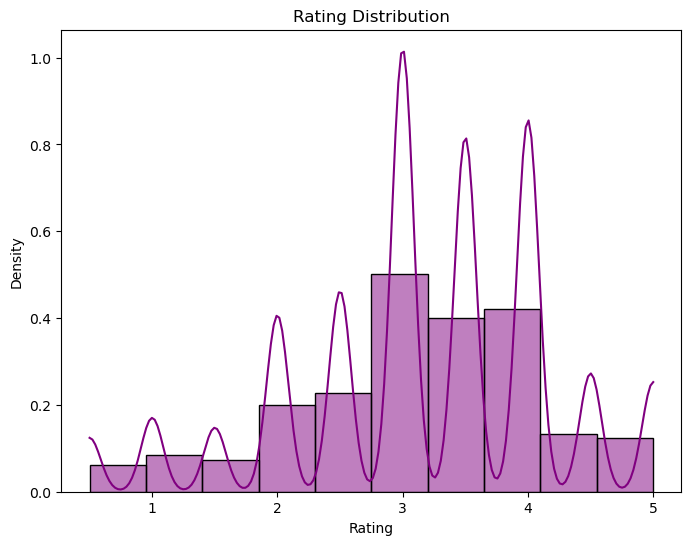

In [33]:
# Visualization 1: Rating Distribution
def plot_rating_distribution():
    plt.figure(figsize=(8, 6))
    sns.histplot(sample_f['rating'], bins=10, kde=True, color='purple', stat='density')
    plt.title('Rating Distribution')
    plt.xlabel('Rating')
    plt.ylabel('Density')
    plt.show()

plot_rating_distribution()


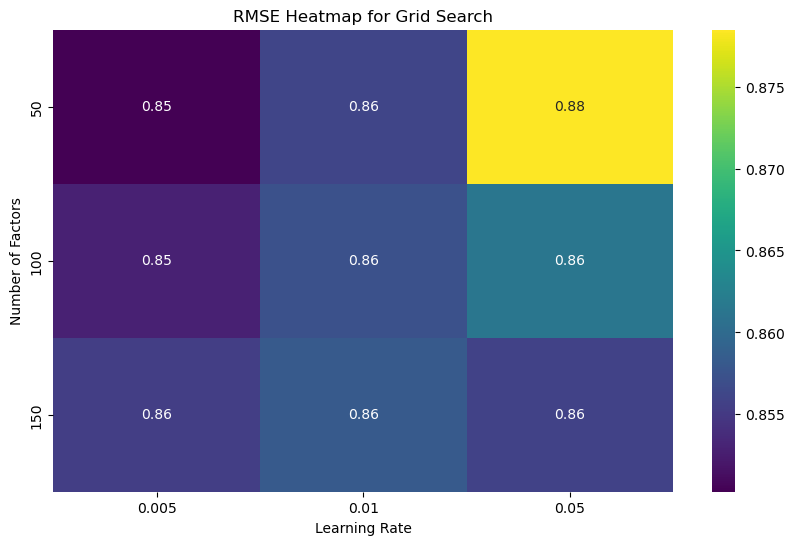

In [34]:

# Visualization 2: Grid Search RMSE/MAE Visualization
def plot_grid_search_results(grid_search):
    results = pd.DataFrame(grid_search.cv_results)
    plt.figure(figsize=(10, 6))
    sns.heatmap(results.pivot_table(index='param_n_factors', columns='param_lr_all', values='mean_test_rmse'), annot=True, cmap='viridis')
    plt.title('RMSE Heatmap for Grid Search')
    plt.xlabel('Learning Rate')
    plt.ylabel('Number of Factors')
    plt.show()

plot_grid_search_results(grid_search)


/var/folders/0_/jyfznr0x5q53rj2pvwf26qbw0000gn/T/ipykernel_6215/2996602955.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=movie_titles, y=predicted_ratings, palette='viridis')


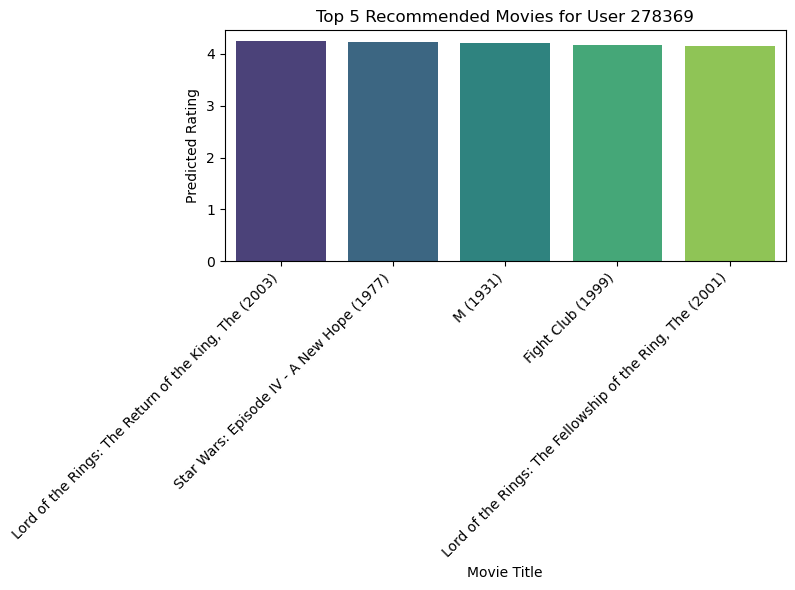

In [35]:

# Visualization 3: Top N Recommended Movies
def plot_top_recommended_movies(recommended_movies):
    movie_titles = [movie[0] for movie in recommended_movies]
    predicted_ratings = [movie[1] for movie in recommended_movies]
    
    plt.figure(figsize=(8, 6))
    sns.barplot(x=movie_titles, y=predicted_ratings, palette='viridis')
    plt.title(f"Top 5 Recommended Movies for User {user_id}")
    plt.xlabel('Movie Title')
    plt.ylabel('Predicted Rating')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

plot_top_recommended_movies(recommended_movies)

### get user

In [36]:
def get_movie_recommendations(user_id, rated_movie_ids, top_n=5):
    # Get all movie IDs
    all_movie_ids = sample_f['movieId'].unique()
    
    # Predict ratings for unrated movies
    predictions = []
    for movie_id in all_movie_ids:
        if movie_id not in rated_movie_ids:
            pred = svd.predict(user_id, movie_id)
            predictions.append((movie_id, pred.est))
    
    # Sort predictions by estimated rating (highest first)
    predictions.sort(key=lambda x: x[1], reverse=True)
    
    # Get top N recommended movies, but limit to a maximum of 5
    top_predictions = predictions[:min(top_n, 5)]  # Limit to 5 movies
    
    # Get movie details for top N movies
    recommendations = []
    for movie_id, pred_rating in top_predictions:
        movie_title = sample_f[sample_f['movieId'] == movie_id]['title'].iloc[0]
        movie_genres = sample_f[sample_f['movieId'] == movie_id]['genres'].iloc[0]
        recommendations.append((movie_title, pred_rating, movie_genres))
    
    return recommendations

In [37]:
def get_user_input():
    try:
        user_id = int(input("Enter your User ID: "))
        rated_movie_ids_input = input("Enter the movie IDs you have already rated, separated by commas: ")
        rated_movie_ids = [int(movie_id) for movie_id in rated_movie_ids_input.split(',')]
        top_n = int(input("Enter the number of movie recommendations you would like (e.g., 5): "))
        
        # Ensure the number of recommendations does not exceed 5
        top_n = min(top_n, 5)
        
        #recommended_movies = get_movie_recommendations(user_id, top_n)
        recommended_movies = get_movie_recommendations(user_id, rated_movie_ids, top_n)
        
        # Display the recommended movies along with predicted ratings and genres
        print(f"\nRecommended Movies for User {user_id}:")
        for movie_title, predicted_rating, genres in recommended_movies:
            print(f"- {movie_title} (Predicted Rating: {predicted_rating:.2f}) | Genres: {genres}")
            
            
        # Create a graph for top N recommended movies
        movie_titles = [movie[0] for movie in recommended_movies]
        predicted_ratings = [movie[1] for movie in recommended_movies]
        
        # Plot the top N recommended movies
        plt.figure(figsize=(8, 5))
        sns.barplot(x=movie_titles, y=predicted_ratings, palette='viridis')
        plt.title(f"Top {top_n} Recommended Movies for User {user_id}")
        plt.xlabel('Movie Title')
        plt.ylabel('Predicted Rating')
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()
    
    except ValueError:
        print("Invalid input. Please enter numeric values for User ID and top N recommendations.")



Recommended Movies for User 123456:
- 12 Angry Men (1957) (Predicted Rating: 4.37) | Genres: Drama
- Pulp Fiction (1994) (Predicted Rating: 4.30) | Genres: Comedy|Crime|Drama|Thriller
- Seven Samurai (Shichinin no samurai) (1954) (Predicted Rating: 4.30) | Genres: Action|Adventure|Drama
- Shawshank Redemption, The (1994) (Predicted Rating: 4.29) | Genres: Crime|Drama
- Casablanca (1942) (Predicted Rating: 4.25) | Genres: Drama|Romance


/var/folders/0_/jyfznr0x5q53rj2pvwf26qbw0000gn/T/ipykernel_6215/1485236143.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=movie_titles, y=predicted_ratings, palette='viridis')


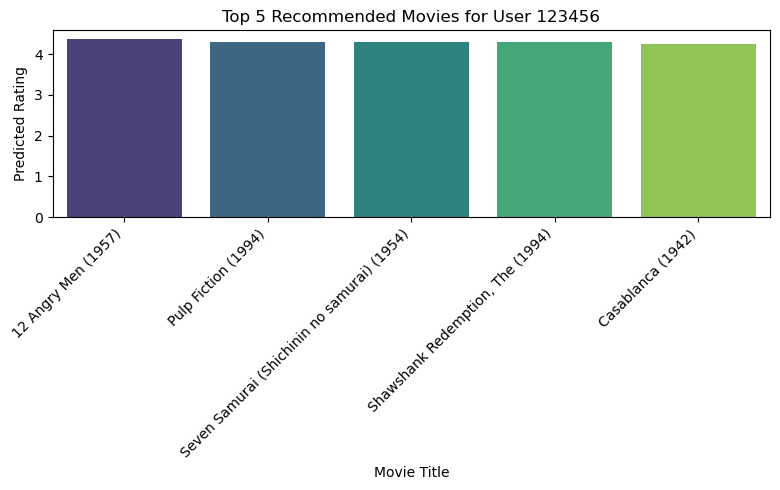

In [38]:

# Call the function to get user input
get_user_input()

In [39]:
def plot_rating_distribution():
    plt.figure